In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import re
import nltk
import time
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#LSTM

In [2]:
class TextPreprocessor:
    def __init__(self, max_words=10000, max_len=100):
        self.max_words = max_words
        self.max_len = max_len
        self.word2idx = {}
        self.idx2word = {}
        self.word_counts = Counter()

    def clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

    def fit(self, texts):
        for text in texts:
            text = self.clean_text(text)
            words = word_tokenize(text)
            self.word_counts.update(words)

        vocab = ['<PAD>', '<UNK>'] + [word for word, count in
                self.word_counts.most_common(self.max_words-2)]

        self.word2idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx2word = {idx: word for idx, word in enumerate(vocab)}

    def transform(self, texts):
        sequences = []
        for text in texts:
            text = self.clean_text(text)
            words = word_tokenize(text)
            seq = [self.word2idx.get(word, self.word2idx['<UNK>'])
                  for word in words[:self.max_len]]

            if len(seq) < self.max_len:
                seq = seq + [self.word2idx['<PAD>']] * (self.max_len - len(seq))
            sequences.append(seq)
        return np.array(sequences)


In [3]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           bidirectional=bidirectional, dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                           output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        return self.fc(hidden)

In [5]:
class TrainingHistory:
    def __init__(self):
        self.train_losses = []
        self.valid_losses = []
        self.train_accs = []
        self.valid_accs = []

    def update(self, train_loss, valid_loss, train_acc, valid_acc):
        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)
        self.train_accs.append(train_acc)
        self.valid_accs.append(valid_acc)

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.valid_losses, 'r-', label='Validation Loss')
        plt.title('Model Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accs, 'b-', label='Training Accuracy')
        plt.plot(epochs, self.valid_accs, 'r-', label='Validation Accuracy')
        plt.title('Model Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer,
                n_epochs, device):
    best_valid_loss = float('inf')
    history = TrainingHistory()

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_acc = 0

        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(text)

            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = torch.argmax(predictions, dim=1)
            train_acc += (predictions == labels).sum().item()

        model.eval()
        valid_loss = 0
        valid_acc = 0

        with torch.no_grad():
            for text, labels in valid_loader:
                text, labels = text.to(device), labels.to(device)

                predictions = model(text)
                loss = criterion(predictions, labels)

                valid_loss += loss.item()
                predictions = torch.argmax(predictions, dim=1)
                valid_acc += (predictions == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader)
        valid_acc = valid_acc / len(valid_loader.dataset)

        history.update(train_loss, valid_loss, train_acc, valid_acc)

        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'lstm_model.pt')

    return history

In [ ]:
def evaluate_model(model, test_loader, device, le):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = le.inverse_transform(y_true)
    y_pred = le.inverse_transform(y_pred)
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
    return cm, le.classes_

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda
Loading data...
Preprocessing text...
Splitting data...
Applying Random Oversampling to balance the dataset...
Initializing model...
Starting training...
Epoch: 1
	Train Loss: 0.612 | Train Acc: 73.34%
	Valid Loss: 0.450 | Valid Acc: 79.57%
Epoch: 2
	Train Loss: 0.448 | Train Acc: 82.22%
	Valid Loss: 0.375 | Valid Acc: 84.88%
Epoch: 3
	Train Loss: 0.358 | Train Acc: 86.48%
	Valid Loss: 0.342 | Valid Acc: 87.00%
Epoch: 4
	Train Loss: 0.306 | Train Acc: 88.51%
	Valid Loss: 0.392 | Valid Acc: 85.52%
Epoch: 5
	Train Loss: 0.266 | Train Acc: 90.13%
	Valid Loss: 0.346 | Valid Acc: 87.80%
Epoch: 6
	Train Loss: 0.231 | Train Acc: 91.57%
	Valid Loss: 0.379 | Valid Acc: 87.35%
Epoch: 7
	Train Loss: 0.209 | Train Acc: 92.43%
	Valid Loss: 0.410 | Valid Acc: 86.98%
Epoch: 8
	Train Loss: 0.192 | Train Acc: 93.00%
	Valid Loss: 0.324 | Valid Acc: 89.62%
Epoch: 9
	Train Loss: 0.171 | Train Acc: 93.78%
	Valid Loss: 0.423 | Valid Acc: 87.58%
Epoch: 10
	Train Loss: 0.155 | Train Acc: 94

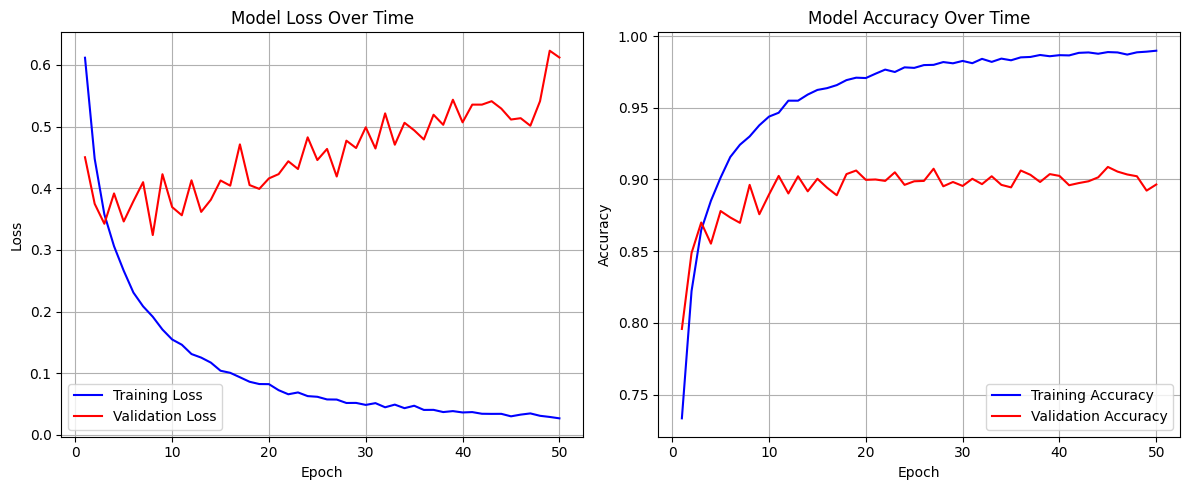

Evaluating model...
              precision    recall  f1-score   support

     Negatif       0.93      0.87      0.90      1744
      Netral       0.42      0.57      0.48       245
     Positif       0.95      0.96      0.95      2011

    accuracy                           0.90      4000
   macro avg       0.77      0.80      0.78      4000
weighted avg       0.91      0.90      0.90      4000



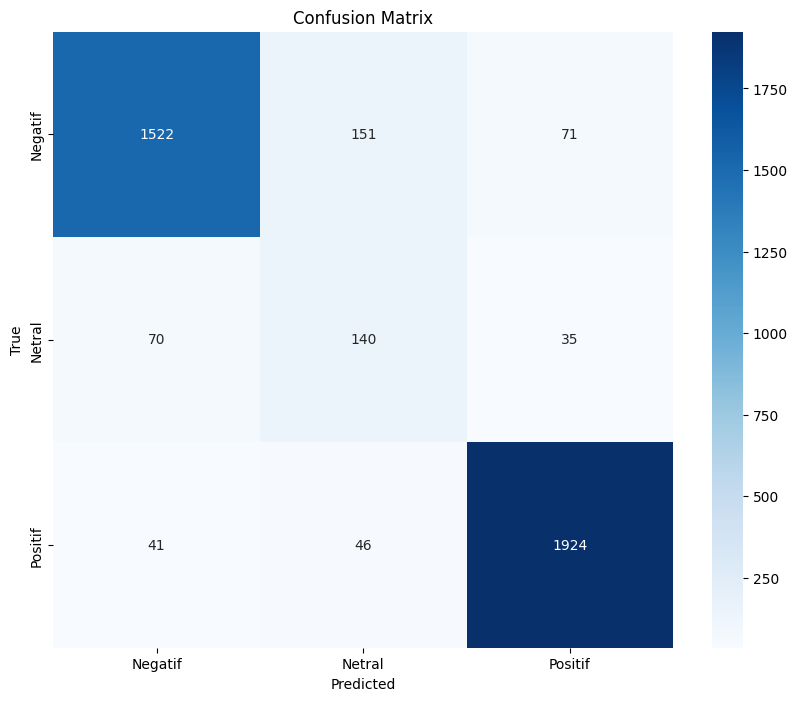

In [ ]:
def main():
    MAX_WORDS = 10000
    MAX_LEN = 100
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    N_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.5
    BATCH_SIZE = 64
    N_EPOCHS = 50
    LEARNING_RATE = 0.0005

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Loading data...")
    df = pd.read_csv('data_labeled.csv')

    print("Preprocessing text...")
    preprocessor = TextPreprocessor(MAX_WORDS, MAX_LEN)
    preprocessor.fit(df['content'])
    X = preprocessor.transform(df['content'])

    le = LabelEncoder()
    y = le.fit_transform(df['sentiment'])

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Random OverSampling...")
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    train_dataset = SentimentDataset(X_train_resampled, y_train_resampled)
    test_dataset = SentimentDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print("Initializing model...")
    model = LSTMSentiment(
        vocab_size=MAX_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=len(le.classes_),
        n_layers=N_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Train Model...")
    history = train_model(model, train_loader, test_loader, criterion, optimizer,
                         N_EPOCHS, device)

    history.plot_metrics()

    print("Eval Model...")
    cm, cm_labels = evaluate_model(model, test_loader, device, le)

    plot_confusion_matrix(cm, cm_labels)

    return history, cm, cm_labels, model, preprocessor, device, le


history, cm, cm_labels, model, preprocessor, device, le = main()

## Inference LSTM

In [ ]:
def load_model(model_path, vocab_size, embedding_dim, hidden_dim, output_dim,
               n_layers, bidirectional, dropout, device):
    model = LSTMSentiment(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_layers=n_layers,
        bidirectional=bidirectional,
        dropout=dropout
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

<ipython-input-19-465cbddaa920>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Masukkan teks (atau ketik 'exit' untuk keluar): aplikasi membantu
Prediksi Sentimen: Positif

Masukkan teks (atau ketik 'exit' untuk keluar): aplikasi jelek
Prediksi Sentimen: Negatif

Masukkan teks (atau ketik 'exit' untuk keluar): kurang bagus
Prediksi Sentimen: Positif

Masukkan teks (atau ketik 'exit' untuk keluar): exit
Terima kasih! Program berhenti.


# SVM

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=5
        )

    def clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

    def fit_transform(self, texts):
        cleaned_texts = [self.clean_text(text) for text in texts]
        return self.vectorizer.fit_transform(cleaned_texts)

    def transform(self, texts):
        cleaned_texts = [self.clean_text(text) for text in texts]
        return self.vectorizer.transform(cleaned_texts)


    def predict(self, text):
        text_tfidf = self.preprocessor.transform([text])
        prediction = self.model.predict(text_tfidf)
        return self.le.inverse_transform(prediction)[0]


In [ ]:
class SVMSentimentAnalyzer:
    def __init__(self):
        self.preprocessor = TextPreprocessor()
        self.model = LinearSVC(random_state=42)
        self.le = LabelEncoder()

    def train(self, X_train, y_train, X_test, y_test):
        start_time = time.time()

        print("Preprocessing data...")
        X_train_tfidf = self.preprocessor.fit_transform(X_train)
        X_test_tfidf = self.preprocessor.transform(X_test)

        y_train_encoded = self.le.fit_transform(y_train)
        y_test_encoded = self.le.transform(y_test)

        print("Training model SVM...")
        self.model.fit(X_train_tfidf, y_train_encoded)

        
        train_predictions = self.model.predict(X_train_tfidf)
        test_predictions = self.model.predict(X_test_tfidf)

        training_time = time.time() - start_time

        results = {
            'training_time': training_time,
            'train_report': classification_report(y_train_encoded, train_predictions,
                                               target_names=self.le.classes_),
            'test_report': classification_report(y_train_encoded, train_predictions,
                                             target_names=self.le.classes_),
            'confusion_matrix': confusion_matrix(y_test_encoded, test_predictions)
        }

        return results


In [4]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Loading data...
Preprocessing data...
Training SVM model...
Making predictions...

Test Set Performance:
              precision    recall  f1-score   support

     Negatif       0.97      0.98      0.98      6959
      Netral       0.97      0.77      0.86       993
     Positif       0.97      0.99      0.98      8048

    accuracy                           0.97     16000
   macro avg       0.97      0.91      0.94     16000
weighted avg       0.97      0.97      0.97     16000



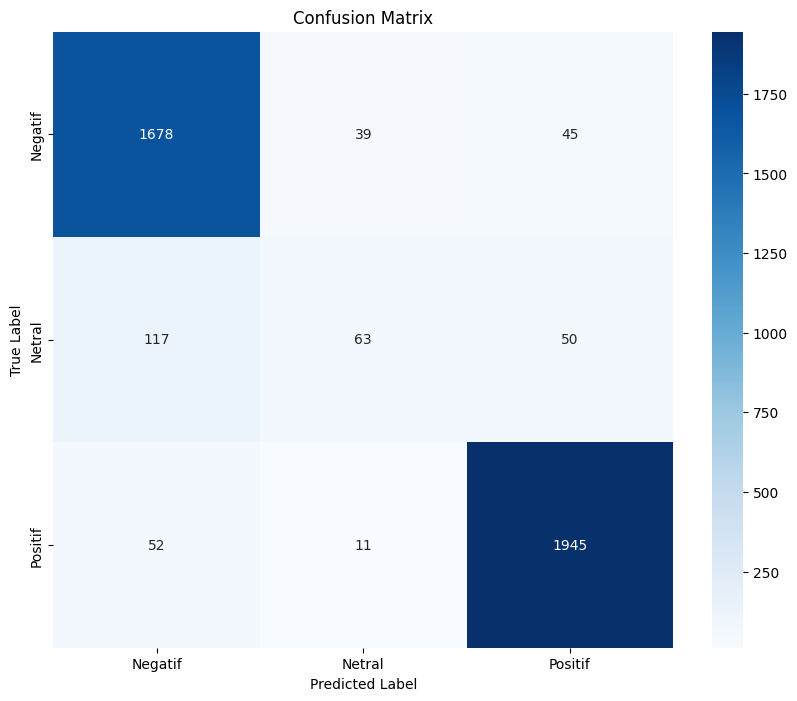

In [ ]:
def main():
    print("Loading data...")
    df = pd.read_csv('data_labeled.csv')  

    X_train, X_test, y_train, y_test = train_test_split(
        df['content'],
        df['sentiment'],
        test_size=0.2,
        random_state=42
    )

    svm_analyzer = SVMSentimentAnalyzer()
    results = svm_analyzer.train(X_train, y_train, X_test, y_test)

    print("\nTest Set Performance:")
    print(results['test_report'])

    plot_confusion_matrix(results['confusion_matrix'],
                         classes=svm_analyzer.le.classes_)

    joblib.dump(svm_analyzer, "svm_sentiment_model.pkl")

if __name__ == "__main__":
    main()

## Inference SVM

In [ ]:
svm_analyzer = joblib.load("svm_sentiment_model.pkl")

def predict_sentiment(text, svm_analyzer):
    """Memprediksi sentimen dari teks input."""
    text_tfidf = svm_analyzer.preprocessor.transform([text])
    prediction = svm_analyzer.model.predict(text_tfidf)
    return svm_analyzer.le.inverse_transform(prediction)[0]

def user_input_inference():
    """Mode interaktif untuk memasukkan teks dan mendapatkan prediksi."""
    while True:
        user_text = input("Masukkan teks (atau ketik 'exit' untuk keluar): ").strip()

        if user_text.lower() == 'exit':
            print("Keluar dari mode inference.")
            break

        predicted_sentiment = predict_sentiment(user_text, svm_analyzer)
        print(f"Prediksi Sentimen: {predicted_sentiment}\n")

user_input_inference()


Masukkan teks (atau ketik 'exit' untuk keluar): aplikasi bagus
Prediksi Sentimen: Positif

Masukkan teks (atau ketik 'exit' untuk keluar): exit
Keluar dari mode inference.


# Transformer

Using device: cuda
Loading dataset...
                           content sentiment
0                          Praktis   Positif
1  Mantaplah mempermudah fasilitas   Positif
2                               Ok   Positif
3                               Ok   Positif
4                             Good   Positif
Class distribution:
sentiment
Positif    10056
Negatif     8721
Netral      1223
Name: count, dtype: int64
Class weights: tensor([0.6630, 0.7644, 5.4511], device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss: 0.6312609495073557, Train accuracy: 0.787
Val loss: 0.47367059826850894, Val accuracy: 0.8565
--------------------------------------------------
Epoch 2/3
Train loss: 0.4183713857382536, Train accuracy: 0.85475
Val loss: 0.3866606325954199, Val accuracy: 0.8715
--------------------------------------------------
Epoch 3/3
Train loss: 0.31922936004865915, Train accuracy: 0.8943125000000001
Val loss: 0.3558533710464835, Val accuracy: 0.905
--------------------------------------------------


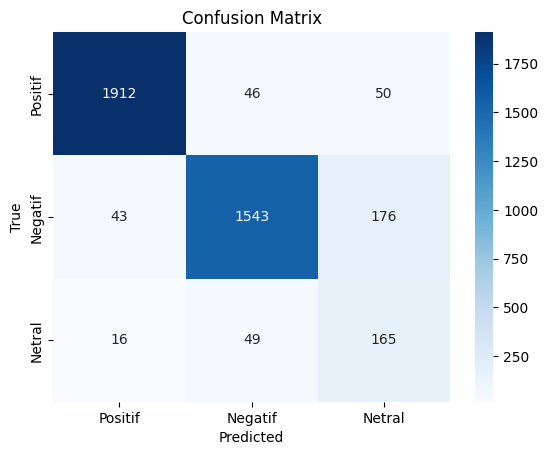

              precision    recall  f1-score   support

     Positif       0.97      0.95      0.96      2008
     Negatif       0.94      0.88      0.91      1762
      Netral       0.42      0.72      0.53       230

    accuracy                           0.91      4000
   macro avg       0.78      0.85      0.80      4000
weighted avg       0.93      0.91      0.91      4000



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading dataset...")
df = pd.read_csv('data_labeled.csv') 
print(df.head())

label_map = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
df['label'] = df['sentiment'].map(label_map)

print("Class distribution:")
print(df['sentiment'].value_counts())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df['content'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)

    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print('-' * 50)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return predictions, real_values

y_pred, y_true = get_predictions(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=label_map.keys()))

## Hasil

          Class  Transformer Precision  Transformer Recall  \
0       Positif                   0.97                0.95   
1       Negatif                   0.94                0.88   
2        Netral                   0.42                0.72   
3      Accuracy                   0.91                0.91   
4     Macro Avg                   0.78                0.85   
5  Weighted Avg                   0.93                0.91   

   Transformer F1-Score  SVM Precision  SVM Recall  SVM F1-Score  \
0                  0.96           0.97        0.99          0.98   
1                  0.91           0.97        0.98          0.98   
2                  0.53           0.97        0.77          0.86   
3                  0.91           0.97        0.97          0.97   
4                  0.80           0.97        0.91          0.94   
5                  0.91           0.97        0.97          0.97   

   LSTM Precision  LSTM Recall  LSTM F1-Score  
0            0.95         0.96          

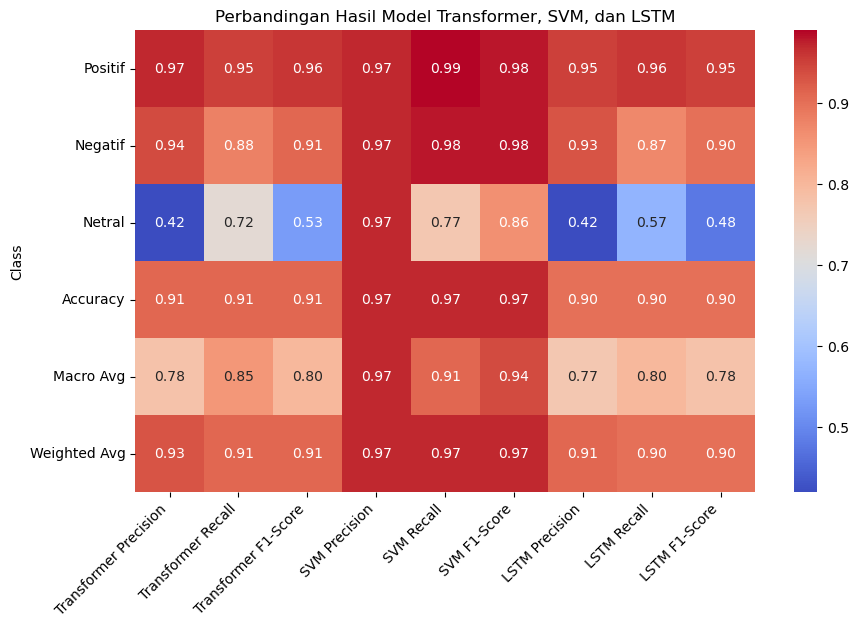

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data hasil evaluasi
model_results = {
    "Class": ["Positif", "Negatif", "Netral", "Accuracy", "Macro Avg", "Weighted Avg"],
    "Transformer Precision": [0.97, 0.94, 0.42, 0.91, 0.78, 0.93],
    "Transformer Recall": [0.95, 0.88, 0.72, 0.91, 0.85, 0.91],
    "Transformer F1-Score": [0.96, 0.91, 0.53, 0.91, 0.80, 0.91],
    "SVM Precision": [0.97, 0.97, 0.97, 0.97, 0.97, 0.97],
    "SVM Recall": [0.99, 0.98, 0.77, 0.97, 0.91, 0.97],
    "SVM F1-Score": [0.98, 0.98, 0.86, 0.97, 0.94, 0.97],
    "LSTM Precision": [0.95, 0.93, 0.42, 0.90, 0.77, 0.91],
    "LSTM Recall": [0.96, 0.87, 0.57, 0.90, 0.80, 0.90],
    "LSTM F1-Score": [0.95, 0.90, 0.48, 0.90, 0.78, 0.90]
}

# Membuat DataFrame
hasil = pd.DataFrame(model_results)

# Menampilkan tabel
print(hasil)

# Visualisasi menggunakan heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hasil.set_index("Class").astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Perbandingan Hasil Model Transformer, SVM, dan LSTM")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd
from tabulate import tabulate

model_results = {
    "Class": ["Positif", "Negatif", "Netral", "Accuracy", "Macro Avg", "Weighted Avg"],
    "Transformer Precision": [0.97, 0.94, 0.42, 0.91, 0.78, 0.93],
    "Transformer Recall": [0.95, 0.88, 0.72, 0.91, 0.85, 0.91],
    "Transformer F1-Score": [0.96, 0.91, 0.53, 0.91, 0.80, 0.91],
    "SVM Precision": [0.97, 0.97, 0.97, 0.97, 0.97, 0.97],
    "SVM Recall": [0.99, 0.98, 0.77, 0.97, 0.91, 0.97],
    "SVM F1-Score": [0.98, 0.98, 0.86, 0.97, 0.94, 0.97],
    "LSTM Precision": [0.95, 0.93, 0.42, 0.90, 0.77, 0.91],
    "LSTM Recall": [0.96, 0.87, 0.57, 0.90, 0.80, 0.90],
    "LSTM F1-Score": [0.95, 0.90, 0.48, 0.90, 0.78, 0.90]
}

hasil = pd.DataFrame(model_results)

print(tabulate(hasil, headers='keys', tablefmt='grid'))


+----+--------------+-------------------------+----------------------+------------------------+-----------------+--------------+----------------+------------------+---------------+-----------------+
|    | Class        |   Transformer Precision |   Transformer Recall |   Transformer F1-Score |   SVM Precision |   SVM Recall |   SVM F1-Score |   LSTM Precision |   LSTM Recall |   LSTM F1-Score |
+====+==============+=========================+======================+========================+=================+==============+================+==================+===============+=================+
|  0 | Positif      |                    0.97 |                 0.95 |                   0.96 |            0.97 |         0.99 |           0.98 |             0.95 |          0.96 |            0.95 |
+----+--------------+-------------------------+----------------------+------------------------+-----------------+--------------+----------------+------------------+---------------+-----------------+
|  1 